# Data exploration

In this notebook, we explore the raw sales and store data.

The final data processing pipeline (cleaning, feature engineering, etc.)
is described in the notebook `0_summary`.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load scripts from parent path
import sys, os
sys.path.insert(0, os.path.abspath('..'))

## Load Data

This table contains the raw daily sales by Rossmann store.

The target column is:
  - `Sales`: The total sum of sales for this store and date

The features columns are:
  - `Date`: The date of the sales record
  - `Store`: An ID of the store
  - `DayOfWeek`: The day of the week, given as an integer, ranging from Monday (0) to Sunday (6).
  - `Open`: Whether the store was open on this date: 0 = closed, 1 = open
  - `Promo`: Whether the store ran a promotion on this date.
  - `StateHoliday`: Whether this date was a state holiday.
  - `SchoolHoliday`: Whether this date was a school holiday.


In [24]:
from scripts.processing import load_train_data, process_data

train_raw = load_train_data()
train = process_data(train_raw, drop_date=False)
train.head()

,Date,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday
27,2013-01-01,353.0,2.0,3139.0,0.0,1.0,1.0
115,2013-01-01,335.0,2.0,2401.0,0.0,1.0,1.0
147,2013-01-01,512.0,2.0,2646.0,0.0,1.0,1.0
162,2013-01-01,494.0,2.0,3113.0,0.0,1.0,1.0
199,2013-01-01,530.0,2.0,2907.0,0.0,1.0,1.0


## Exploration

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440048 entries, 27 to 637773
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           440048 non-null  datetime64[ns]
 1   Store          440048 non-null  float64       
 2   DayOfWeek      440048 non-null  float64       
 3   Sales          440048 non-null  float64       
 4   Promo          440048 non-null  float64       
 5   StateHoliday   440048 non-null  float64       
 6   SchoolHoliday  440048 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 26.9 MB


### Total sales

 - The total sales over time are dominated by the weekly pattern (few sales on sunday).
 - We see fluctuations especially around holidays (see easter, christmas)
 - There does not seem to be a strong trend.

In [26]:
sales = train.groupby(by='Date').agg({'Sales': 'sum'})

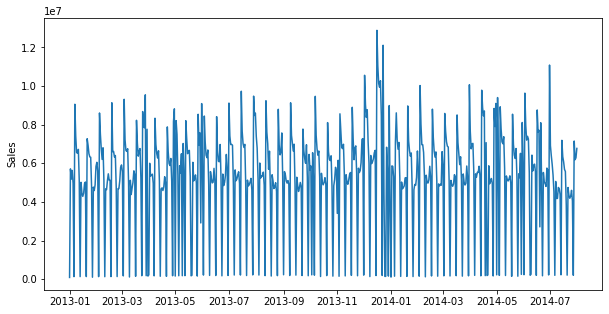

In [27]:
fig = plt.figure(figsize=(10,5))
plt.plot(sales)
plt.ylabel('Sales')
plt.show()

Do all dates in the time range have a sale?

-> All dates in the time range have sales

In [28]:
n_dates = len(sales.index)
print(n_dates)
dates = pd.date_range(start=sales.index.min(), end=sales.index.max())
print(len(dates))

577
577


### State Holidays

- Only a small fraction of dates are holidays
- However, sales show deviations around holidays, so probably important

In [29]:
train.loc[:, 'StateHoliday'].value_counts()

4.0    439565
1.0       368
2.0        82
3.0        33
Name: StateHoliday, dtype: int64

### Stores

- How many stores are they?
- How are sales distributed among them?

In [30]:
store_counts = train.loc[:, 'Store'].value_counts()
print(f"There are {len(store_counts)} stores")
store_counts

There are 1115 stores


733.0     500
335.0     489
769.0     483
948.0     482
682.0     480
         ... 
972.0     346
348.0     340
1081.0    338
349.0     332
103.0     281
Name: Store, Length: 1115, dtype: int64

- Interesting: The number of days that a store has sales is bimodal.
- Hypothesis: The two groups are stores that are open on Sunday, and those that are not.

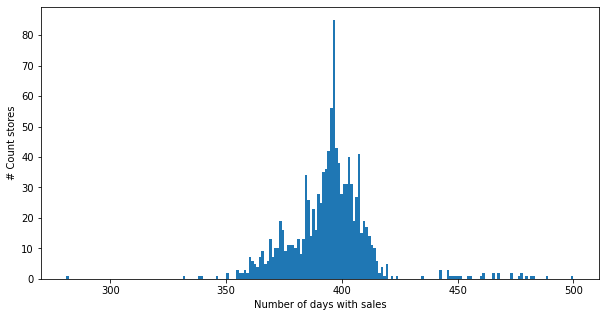

In [31]:
fig = plt.figure(figsize=(10,5))
plt.hist(store_counts, bins=200)
plt.xlabel("Number of days with sales")
plt.ylabel("# Count stores")
plt.show()

 - The distribution of sales per store is pretty normal (log-normal?)
 - It is skewed with a fat tail at high sales, but not apparent outliers.

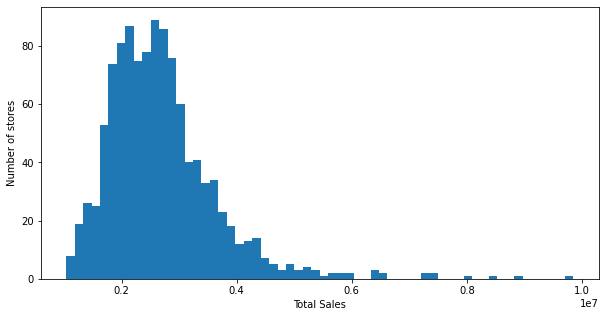

In [32]:
sales_by_store = train.groupby(by='Store').agg({'Sales': 'sum'}).sort_values(by='Sales', ascending=False)

plt.figure(figsize=(10,5))
plt.hist(sales_by_store['Sales'], bins=60)
plt.xlabel("Total Sales")
plt.ylabel("Number of stores")

plt.show()

## DayOfWeek

 - DayOfWeek ranges from 1 (monday) to 7 (sunday).
 - There are much fewer records for sunday, because most stores a closed.
 - However, average sales for sunday are actually quite high - if a store is open on sunday it makes good sales

In [33]:
train.loc[:, 'DayOfWeek'].value_counts()

2.0    75313
6.0    75281
3.0    73284
5.0    72744
1.0    71497
4.0    70116
7.0     1813
Name: DayOfWeek, dtype: int64

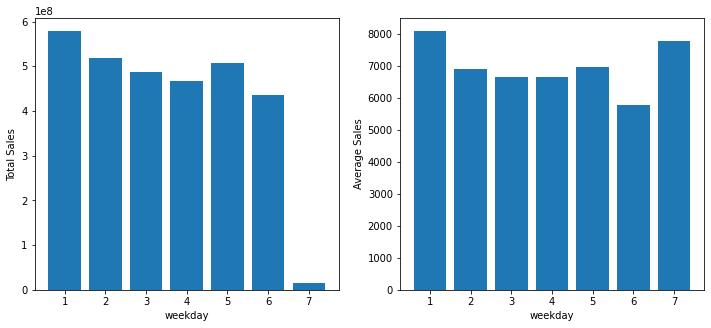

In [34]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sales_per_weekday = train.groupby(by='DayOfWeek').agg({'Sales': ['mean', 'sum']})
axes[0].bar(sales_per_weekday.index, height=sales_per_weekday['Sales']['sum'])
axes[0].set_xlabel('weekday')
axes[0].set_ylabel('Total Sales')
axes[1].set_xlabel('weekday')
axes[1].set_ylabel('Average Sales')
axes[1].bar(sales_per_weekday.index, height=sales_per_weekday['Sales']['mean'])
plt.show()


## Feature Correlations

 - There is a relatively high correlation between sales and promotions.
 - Various numerical features do not exhibit extremely high correlations. Therefore, we keep all of them.

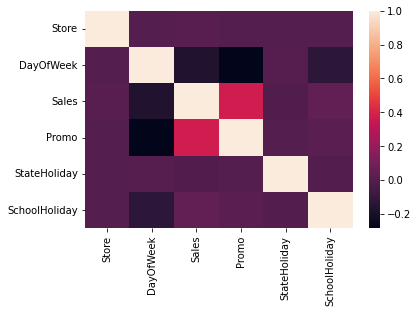

In [35]:
sns.heatmap(train.corr());

## Store exploration

Some additional data on stores is provided.

We did a more thorough analysis of this in the notebook `util_extract_store_info`

In [36]:
store_raw = pd.read_csv("../data/store.csv")
store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [37]:
store_raw['StoreType']

0       c
1       a
2       a
3       c
4       a
       ..
1110    a
1111    c
1112    a
1113    a
1114    d
Name: StoreType, Length: 1115, dtype: object